In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
# from PIL import Image

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

In [2]:
%matplotlib widget

In [3]:
input_dir = r"D:\RECTDNN\uncompress\\"
proc_dir  = r"D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\"

In [4]:
stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")

init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

In [5]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{input_dir}/*480287*")
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(input_dir + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

with open(f"{data_dir}/AAA_ReferenceDatasets/IndexCoords.pkl", 'rb') as handle:
    dict = pickle.load(handle)

We create the tile database with the detected tiles

In [6]:
duplicate_db, non_dupped_dict, dupped_dict = buildDetectedDatabase(dict)

print(len(non_dupped_dict), len(dupped_dict))  

detected_tiles = pd.DataFrame.from_dict(non_dupped_dict).T
detected_tiles['geometry'] = detected_tiles['coords'].apply(bbox_to_polygon)
detected_tiles_gdf = gpd.GeoDataFrame(detected_tiles)
detected_tiles_gdf = detected_tiles_gdf[['geometry']]

2190 1493


Here we supplement that database with all existing world files...

In [7]:
fn = os.path.join(proc_dir, "WorldFileDatabase.feather")
if os.path.exists(fn):
    df = pd.read_pickle(fn)
else:
    df = buildWorldFileDatabase(input_dir, duplicate_db, stateplanes)
    df.to_pickle(fn)

In [8]:
# Apply the function to the 'bbox' column
df['geometry'] = df['webmerc'].apply(bbox_to_polygon)
gdf = gpd.GeoDataFrame(df)
gdf.dropna(axis=0)

for key in gdf.keys():
    if key == 'geometry':
        continue
    gdf[key] = gdf[key].astype(str)

gdf.to_file(r"D:\RECTDNN\WorldFiles.shp")
detected_tiles_gdf.to_file(r"D:\RECTDNN\Detected.shp")

In [9]:
def runYOLO_Text(image_fn, model=None, 
        model_weights=f"{data_dir}BBNN/weights042924.pt",
        save_dir=None,
        device="cuda",
        verbose=True,
        get_data = True,
        find_text = True,
        keyed_text = False,
        target_size = 1920,
        conf_threshold = 0.92,
        ret_values=False,
        plot_params = {}
        ):
    
    
    input_folder = os.path.dirname(os.path.abspath(image_fn))

    # INITIALIZE MODEL AS NEEDED
    if model is None:
        model = ultralytics.YOLO(model_weights).to("cpu")
    model = model.to(device)
    
    # RUN MODEL
    results = model(image_fn, imgsz=target_size, verbose=verbose)

    if device == "cuda":
        results = [result.cpu() for result in results]
        model   = model.to("cpu")

    # FIND KEY FOR FILE
    basen = os.path.basename(results[0].path)[:-4]
    key = findKey(basen)
    
    ''' UPDATE 06/04/24 WE ARE NO LONGER RESIZING BEFORE INFERENCE SO I'M REMOVING TO OPIMIZE
    # GOTTA FIND CORRECT FILE BC RESIZED WERE SAVED WITH PNG EXTENSION
    in_fn = glob.glob(os.path.join(input_folder,  basen + '*[!w]'))[0]
    image = Image.open(in_fn)
    width, height = image.size
    im_size_arry  = np.array([width, height, width, height])
    '''
    # LOAD IMAGE FROM RESULTS AND GET DIMENSIONS
    # TODO: DOUBLE CHECK DIMENSION ORDER HERE
    image = results[0].orig_img
    if image.ndim == 3:
        width, height, _ = image.shape
    else:
        width, height = image.shape
    im_size_arry  = np.array([height, width, height, width,])

    # ONLY SPEND TIME TO CONVERT IMAGE IF WE ARE ACTUALLY USING IT TO EXTRACT DATA
    if get_data:
        image = Image.fromarray(image)

    # OUTPUT STRUCTURE
    outputs = {}
    
    # YOLO CONFIDENCE
    conf = results[0].boxes.data.numpy()[:, -2] # GET CONFIDENCE LEVELS
    slice = conf > conf_threshold               # SLICE CONFIDENCE LEVELS WITH THRESHOLDS

    # FOR EACH RESULT 
    for i in range(results[0].boxes.xyxyn.numpy().shape[0]): # np.where(slice)[0]: 
        
        # GET BBOX DATA
        bbox = results[0].boxes.xyxyn.numpy()[i]

        if get_data:
            data = extract_bounded_area(image, bbox)
        else:
            data = None

        bbox = bbox * im_size_arry

        # FIND TE
        if find_text:
            text = pytesseract.image_to_string(data, config='--psm 12 --oem 3') # -c tessedit_char_whitelist=0123456789

            if keyed_text:
                word = find_word_with_key(text, key, threshold=80, verbose=False)

                if isinstance(word, list):
                    word = ",".join(word)
            else:
                word = None
        else:
            text, word = None, None

        outputs[i] = {"bbox" : bbox, "data" : data, "text" : text, "keyed_text" : word, "confidence" : conf[i]}

    if save_dir is not None:
        results[0].save(save_dir, **plot_params)

    if ret_values:
        return outputs, model, results[0]
    return outputs, model
FANN_prior = None
RLNN_prior = None
model = None

color=False

plot_params = {"labels" : False, }
YOLO_params = {
    "device"  : "cuda",     "find_text" : False, 
    "keyed_text"  : False,  "verbose" : False,  "get_data"  : False,
    "target_size" : 1920,   "plot_params" : plot_params, "ret_values" : True
}

# IF WE'VE ALREADY STARTED PROCESSING THINGS, LOAD STATE DICT
if os.path.exists(f'{proc_dir}results.pkl'):
    print("FOUND DICTIONARY, LOADING")
    with open(f'{proc_dir}results.pkl', 'rb') as handle:
        results_struct = pickle.load(handle)
else:
    results_struct = {}

# LOOP FOR EACH TILE
for i, tile in tqdm(enumerate(tiles), total=len(tiles)):
    
    # DEFINE WHERE GEOREFERENCED TILE IS SAVED
    out_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_FANN.png")
    fin_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_results.pkl")

    # HAVE WE ALREADY PROCESSED THIS TILE? IF SO, SKIP
    if results_struct.get(tile, None):
        # print(f"Found in dict, skipping {tile}")
        continue

    # WHICH VERSION OF FANN ARE WE USING
    if color:
        # RUN AND SAVE PREPROCESSING FANN AND RLNN
        prepped_fn = os.path.join(proc_dir, os.path.basename(tile).split(".")[0] + "_prepped.png")                      # FILE NAME
        prepped, FANN_prior, RLNN_prior, bounds = findStreetCorners_colorPrep(tile, FANN=FANN_prior, RLNN=RLNN_prior)   # RUN FANN_PRIOR AND RLNN
        Image.fromarray(prepped).save(prepped_fn) # SAVE

        # RUN FANN
        results, model, base = runYOLO_Text(prepped_fn, model=model, model_weights=f"{data_dir}FANN/YOLO/051624.pt", **YOLO_params)
        
    else:
        bounds = None

        # RUN FANN
        results, model, base = runYOLO_Text(tile, model=model, model_weights=f"{data_dir}FANN/YOLO/051624_bw.pt", **YOLO_params)

    results_struct[tile] = results

    ''' IF YOU WANT TO SAVE DETAILED OUTPUT, THIS CODE WORKS, BUT IT'S HELLA SLOW AND BURDENSOME
    temp_dict = {"results" : results, "bounds" : bounds, "results_2" : base}
    results_struct[tile] = fin_fn
    if os.path.exists(fin_fn):
        os.remove(fin_fn)
    with open(fin_fn, 'wb') as handle:
        pickle.dump(temp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    '''
    # print(sys.getsizeof(results_struct))

    
    # SAVE EVERY N ITERATIONS AND LAST
    if i % 60 == 0 or i == len(tiles) - 1:
        file_path = f'{proc_dir}results.pkl'
        if os.path.exists(file_path):
            os.remove(file_path)
        with open(file_path, 'wb') as handle:
            pickle.dump(results_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

FOUND DICTIONARY, LOADING


  0%|          | 0/220 [00:00<?, ?it/s]

71


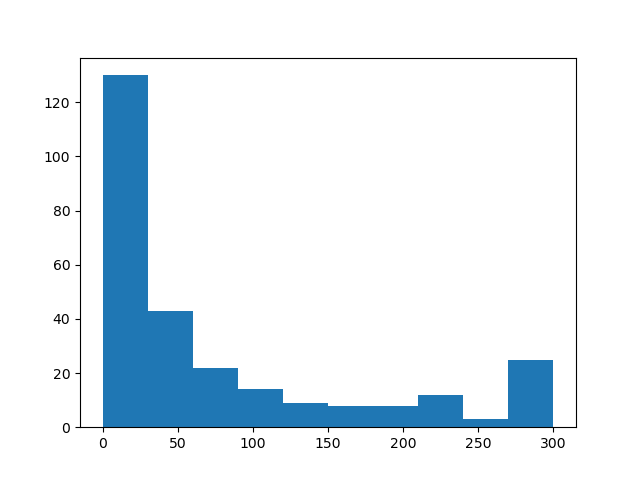

In [10]:
amount_of_corners = np.array([len(results_struct[list(results_struct.keys())[i]]) for i in range(len(results_struct))])
_ = plt.hist(amount_of_corners)
print(np.count_nonzero(amount_of_corners <= 10))

In [11]:
def bboxTransformToCRS(transform, image):
    rev_y_axis = np.array([[1, 0, 0],
                        [0,-1, 0],
                        [0, 0, 1]])
    
    translation = np.eye(3)
    translation[1, 2] = image.shape[0]

    return transform @ translation @ rev_y_axis


def bbox_to_coords_realworld(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_max, y_min, y_min, y_max]
    return xs, ys

def bbox_to_coords_raster(bbox):
    # BOUNDING BOX 

    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_min, x_max, x_max]
    ys = [y_min, y_max, y_max, y_min]
    return xs, ys

bad = 0
RLNN = None

detected_tiles['reference_name'] = detected_tiles.index
list_tiles = list(detected_tiles_gdf.index)

tile_coords = {}
debug_struct = {}
for i, tile in tqdm(enumerate(tiles), total=len(tiles)):

    comp_length = len(tiles_bns[i]) - 2
    curr_tiles = [a if comp_length <= len(a) else "" for a in list_tiles]

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", os.path.basename(tile))
    
    # PERFORM MATCHING
    match, score = process.extractOne(tiles_bns[i], list_tiles)
    matches = process.extract(tiles_bns[i], curr_tiles)
    out_fn = os.path.join(proc_dir, tiles_bns[i] + ".tif")
    
    if score > 90:
        image = np.asarray(Image.open(tile))

        if np.max(image) < 255:
            image = image * 255
            image = image.astype(np.uint8)

        tile_coords[out_fn] = detected_tiles.loc[match]
        tile_coords[out_fn]['input_file'] = tile

        bounds, RLNN = findBounds(tile, RLNN)
        
        if len(bounds[0]) < 1:
            print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile}")
            
            bbox = [0, 0, image.shape[0], image.shape[1]]
        else:
            bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        
        real_x, real_y = bbox_to_coords_realworld(tile_coords[out_fn]["coords"])
        pic_x, pic_y   = bbox_to_coords_raster(bbox)

        # transform = similarityTransformation(pic_x, pic_y, real_x, real_y)
        affine = affineTransformation(pic_x, pic_y, real_x, real_y)
        transform = bboxTransformToCRS(affine.matrix, image)

        # print(*transform.flatten()[:6])

        debug_struct[out_fn] = {
            "match"  : match,  "basename" : tiles_bns[i],
            "matches": matches,
            "real_x" : real_x, "real_y" : real_y,
            "pic_x"  : pic_x,  "pic_y"  : pic_y,
            "affine" : affine, "transform" : transform
        }
        try:
            with rio.open(out_fn, 'w',
                driver='GTiff', count=1, dtype=image.dtype,
                height=image.shape[0], width=image.shape[1],
                crs=f'EPSG:3857',
                transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1) 
        except: 
            print(f"Could not save {tiles_bns[i]}")
                
    else:
        tile_coords[out_fn] = None
        bad = bad + 1

  0%|          | 0/220 [00:00<?, ?it/s]

COULD NOT FIND BOUNDS, USING IMAGE EXTENTS D:\RECTDNN\uncompress\4802870260E.jpg
Could not save 4802870160E


In [12]:
intersections = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/Intersections.gpkg", engine='pyogrio', use_arrow=True)

In [15]:
def calcCenter(a):
    # print(a,  (a[0] + a[2]) / 2, (a[1] + a[3]) / 2)
    return (a[0] + a[2]) / 2, (a[1] + a[3]) / 2

for i, (out_name, db) in enumerate(tile_coords.items()):
    if db is not None:
        
        # GET STREET CORNERS FROM TPNN OUTPUTS
        street_corners = results_struct[tile_coords[out_name]['input_file']]

        # SKIP IF TOO FEW CORNERS
        if len(street_corners) < 20:
            continue

        # OPEN RASTER AND GET BOUNDING BOX
        ra = rio.open(out_name)
        bounds  = ra.bounds

        # CONVERT STREET CORNERS TO NUMPY ARRAY
        street_corners_arry = np.array([calcCenter(street_corners[a]['bbox']) for a in street_corners])

        # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
        xs, ys = rio.transform.xy(ra.transform, street_corners_arry[:, 1], street_corners_arry[:, 0])
        print(out_name, len(xs))
        
        # GET IDENTIFIED STREET INTERSECTIONS
        xy = list(zip(xs, ys))
        points = MultiPoint(xy)
        TLNN = gpd.GeoDataFrame(index=[0], geometry=[points]).explode(ignore_index=False, index_parts=False)

        # GET SHAPEFILE OF STREET INTERSECTIONS
        bounds_poly = enlarged_bounds(ra, n=1.5)
        STCN = gpd.clip(intersections, bounds_poly)

        best_transform, transform_dict = performICPonTile(TLNN, STCN, plot=False,)

        raster_name = os.path.join(proc_dir, os.path.basename(out_name).split(".")[0] + "_registered.tif")
        transform = best_transform @ getMatrixFromAffine(ra.transform) 
        image = ra.read(1)
        
        with rio.open(raster_name, 'w',
            driver='GTiff', count=1, dtype=image.dtype,
            height=image.shape[0], width=image.shape[1],
            crs=f'EPSG:3857',
            transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1) 

D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870145D.tif 46
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870510E.tif 58
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870165E.tif 173
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870130D.tif 27
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870485D.tif 22
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870310D.tif 285
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870140D.tif 20
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870260E.tif 64
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870180E.tif 300
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870170E.tif 300
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870035D.tif 58
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870065E.tif 252
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870305E.tif 124
D:\RECTDNN\processing\2024-05-31_14-05-48\Tiles\\4802870200C.tif 33
D:\RECTDNN\processing\2024-05-31_14-05-48\

In [ ]:
def plotICP_streets(reprojected_points, initial=None, plot_skip=2, best=None):
    # print(initial)
    colors = ['b', 'g']
    icp_iterations = len(reprojected_points)
    fig, ax = plt.subplots()
    colormap = plt.get_cmap('cool') 

    for i in np.arange(plot_skip, icp_iterations, plot_skip):
        ax.scatter(reprojected_points[i][:, 0], reprojected_points[i][:, 1], 
            color=colormap(i / icp_iterations), s=1, label=f"Iteration {i}")
        
    if initial is not None:
        for i, (k, v) in enumerate(initial.items()):
            ax.scatter(v[:, 0], v[:, 1], label=k, color=colors[i], s=2, marker='x')
        pass
    if best is not None:
        ax.scatter(best[:, 0], best[:, 1], color='red', s=2, marker='x', label="Best Fit")
        
    ax.legend()
    ax.grid()
    ax.axis("equal")
    return ax

def performICPonTile(TLNN, STCN, 
                debug=False, 
                plot=True,
                icp_iterations=30, 
                rotation=True, 
                shear=False, 
                perspective=False):
    
    
    # COORDINATE HANDLING
    # coords_TLNN = np.vstack((TLNN[0, :], TLNN[1, :], np.ones(TLNN[1, :].shape))).T
    # coords_STCN = np.vstack((STCN[0, :], STCN[1, :], np.ones(STCN[1, :].shape))).T

    # MAKE SURE BOTH HAVE COORDINATES
    STCN['x'] = STCN['geometry'].x
    STCN['y'] = STCN['geometry'].y
    TLNN['x'] = TLNN['geometry'].x
    TLNN['y'] = TLNN['geometry'].y

    # GET POINT STRUCTURES
    coords_TLNN = np.array(TLNN[['x', 'y']]) 
    coords_STCN = np.array(STCN[['x', 'y']])
    
    # FAST SEARCH STRUCTURE
    kdtree = cKDTree(coords_STCN)
    
    # ITERATIVE CLOSEST POINT STRUCTURES
    reprojected_points    = []
    compounded_homography = np.eye(3)
    proc_points = coords_TLNN
    
    # OUTPUT STRUCTURES
    transforms, grades = [], []
    initial = {"shp" : coords_STCN, "detected" : coords_TLNN}
    
    # ITERATE
    for i in tqdm(range(icp_iterations), disable=True):

        # SEARCH CLOSEST POINT IN KDTREE
        _, nearest_indices = kdtree.query(proc_points)
        to_points = np.array([coords_STCN[idx] for idx in nearest_indices])
        
        # TAKE ADJUSTMENT STEP
        new_homography = adjustStep_affine(proc_points, coords_STCN, kdtree,
                                        shear=shear, rotation=rotation, perspective=perspective)
        # print(new_homography)
        
        if debug:
            fig, ax = plt.subplots()
            ax.scatter(proc_points[:, 0], proc_points[:, 1])
            ax.scatter(coords_STCN[:, 0], coords_STCN[:, 1])
            ax.scatter(to_points[:, 0], to_points[:, 1])
    
            for i in range(proc_points.shape[0]):
                plt.plot([proc_points[i, 0], to_points[i, 0]],
                            [proc_points[i, 1], to_points[i, 1]], 'ko', linestyle="--")
            plt.show()
        
        transform = new_homography.copy()
        
        # APPLY TRANSFORM FROM ADJUSTMENT TO PROCESSING POINTS AND APPEND TO LIST
        reprojected_points.append(applyTransform(transform, proc_points))
    
        proc_points = applyTransform(transform, proc_points)
        if debug:
            plt.scatter(proc_points[:, 0], proc_points[:, 1])
            plt.scatter(coords_STCN[:, 0], coords_STCN[:, 1])
            plt.scatter(to_points[:, 0], to_points[:, 1])
            plt.show()
            
        # COMPOUND TRANSFORMATION
        compounded_homography = compounded_homography @ transform

        # PUT ON OUTPUT STRUCTURES
        transforms.append(compounded_homography)
        grades.append(gradeFit(proc_points, kdtree))
        
        if i % 1 == 0:
            scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
            offset = np.sqrt((new_homography[1, 2] ** 2 + new_homography[0, 2] ** 2) / 2)
            # print(f"Scale: {scale:.2f} Offset: {offset:.2f}")

    # GET BEST TRANSFORMS
    best_transform = transforms[np.argmin(grades)]
    best_points    = reprojected_points[np.argmin(grades)]
    
    if debug:
        plt.plot(range(len(grades)), grades)
        plt.scatter(np.argmin(grades), grades[np.argmin(grades)])
        plt.show()
    
    if plot:
        plotICP_streets(reprojected_points, initial=initial, plot_skip=5, best=best_points)
        plt.show()
    
    transform_dict = {
        "initial" : initial,
        "reproj"  : reprojected_points,
        "best"    : best_transform,
        "list"    : transforms,
        "grades"  : grades
    }

    return best_transform, transform_dict